### TO DO 
* Include account attributes in query  
* Append account attributes to final output  
* Script to generate more summary statistics for output
* Fix pdf output  
* Fix regex group error https://stackoverflow.com/questions/39901550/python-userwarning-this-pattern-has-match-groups-to-actually-get-the-groups  
* Add gephx file output

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
#import pyodbc
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

conn = sqlite3.connect('demo_data.db')

In [2]:
# if using live datamart
t_sql_query = '''
select  a.member_nbr [source], concat((c.first_name + space(1) + c.last_name + space(1)),  a.individual_id) [target] , a.participation_type
from membershipparticipant_today a

--left join agr_membertotal_today b on a.member_nbr = b.member_nbr
left join individual_today c on a.individual_id = c.individual_id
'''

# if using sqlite demo database
sqlite_query = '''
select  a.member_nbr [source], c.first_name || ' ' || c.last_name || ' '||  a.individual_id [target] , a.participation_type
from membershipparticipant_today a

--left join agr_membertotal_today b on a.member_nbr = b.member_nbr
left join individual_today c on a.individual_id = c.individual_id
'''

In [3]:
def get_network_members(degree_dictionary):
    td = pd.DataFrame.from_dict(degree_dictionary)
    names = td.loc[td[0].str.contains(r"([" "] | [a-z])", na=False)]
    names = names.rename(columns={0:'name/individual ID', 1:'degrees'})
    member_nbrs = td.loc[~td.index.isin(names.index)]
    member_nbrs = member_nbrs.rename(columns={0:'member_nbr', 1:'degrees'})

    return(names, member_nbrs)

def generate_color_map(graph_object):
    individual_nodes = []
    for name in list(graph_object.nodes):
        if " " in str(name):
            individual_nodes.append(name)
    
    for n in graph_object.nodes:
        graph_object.nodes[n]['color'] = 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph_object.nodes(data = True)]
    return(colors)

In [4]:
d = pd.read_sql(sqlite_query, conn)
d

,source,target,participation_type
0,6644,Jessica Pratt 6513,101
1,4684,Nathan Mcintyre 3084,101
2,8708,Lilly Wood 6606,101
3,2464,Tyler Welch 3783,101
4,4364,Bryce Andrade 4951,101
...,...,...,...
145,5219,Kayla Freeman 5732,101
146,7116,Sawyer Phillips 3286,101
147,4883,Brooklyn Hartman 5156,101
148,3406,Delilah Xiong 6612,101


### Basic stats

In [5]:
G = nx.from_pandas_edgelist(d, edge_attr = True)
print(nx.info(G))
print('connected components: ' +str(nx.number_connected_components(G)))

Name: 
Type: Graph
Number of nodes: 198
Number of edges: 150
Average degree:   1.5152
connected components: 48


In [6]:
# Degrees
degree = nx.degree(G)
degree

DegreeView({6644: 6, 'Jessica Pratt 6513': 1, 4684: 5, 'Nathan Mcintyre 3084': 1, 8708: 1, 'Lilly Wood 6606': 1, 2464: 1, 'Tyler Welch 3783': 1, 4364: 3, 'Bryce Andrade 4951': 1, 5576: 1, 'Autumn Short 4197': 2, 4369: 3, 'Rebecca Robinson 925': 1, 1761: 1, 'Kylie Sanford 4564': 1, 4772: 1, 'Cole Tyler 2760': 2, 2222: 2, 'Cecilia Melton 421': 1, 1681: 1, 'Bryson Cisneros 8251': 1, 5026: 3, 'Calvin Rhodes 4914': 1, 7497: 1, 'Colton Hurley 9640': 1, 6355: 2, 'Ryker Lam 7349': 2, 6486: 1, 'London Marsh 5674': 1, 4314: 1, 'Zoe Fischer 4061': 2, 7269: 3, 'Graham Miranda 4078': 2, 2832: 2, 'Landon Wall 8503': 1, 5476: 2, 'Willow Velazquez 3795': 1, 5351: 1, 'Kaiden Mclaughlin 2470': 1, 5452: 1, 'Jayla Hayden 5725': 1, 6779: 2, 'Cameron Carrillo 9784': 2, 1586: 2, 'Alice Dejesus 6300': 1, 8652: 2, 'Vincent Andrade 141': 1, 1906: 4, 'Ariel Russell 4469': 1, 6014: 1, 'Jason Gregory 9112': 2, 4315: 2, 'Mason Levy 336': 4, 2585: 2, 'Rose Barber 1020': 1, 6893: 1, 'Kaylee Fernandez 3853': 1, 3552: 

[6, 1, 5, 1, 1, 1, 1, 1, 3, 1, 1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 2, 3, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 4, 1, 1, 2, 2, 4, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3, 1, 2, 2, 2, 2, 3, 2, 3, 1, 2, 2, 1, 1, 4, 3, 4, 1, 2, 2, 3, 3, 2, 1, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 1, 1, 4, 1, 2, 3, 2, 1, 2, 1, 1, 2, 3, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


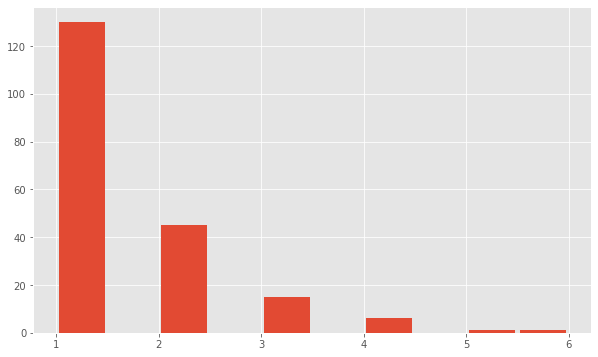

In [7]:
#Degree histogram
plt.rcParams['figure.figsize'] = (10, 6)
degrees = [node[1] for node in degree]
print (degrees)
plt.hist(degrees, bins=10, rwidth=0.9)
plt.show()

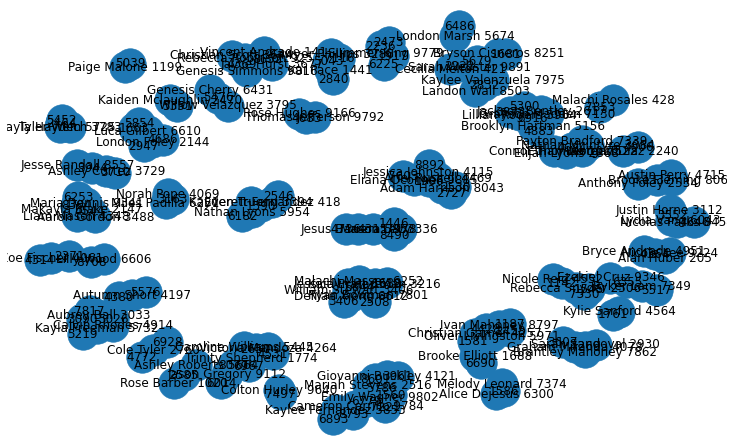

In [10]:
# Show all participants
pos = nx.spring_layout(G)
nx.draw(G, pos=pos,   node_size=1000)
nx.draw_networkx_labels(G, pos=pos )
plt.show()

### Data prep and examining subgraphs

In [12]:
# make subgraphs from all the connected components within the original dataset
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

In [15]:
# node count summary statisitcs of subgraphs
node_count = []
for sub in S:
    count = len(nx.nodes(sub))
    node_count.append(count)
    
print(f'min nodes {min(node_count)}')
print(f'max nodes {max(node_count)}')
print(f'average nodes {sum(node_count)/len(node_count)}')


min nodes 2
max nodes 10
average nodes 4.125


In [19]:
# filter for subgraphs with n nodes

n =6 
multi=[]
for sub in S:
    nodes = nx.nodes(sub)
    node_count = len(nodes)
    if node_count>=n:
        multi.append(sub)

print(f'{len(multi)} networks of with at least {n} nodes')

12 networks of with at least 6 nodes


In [29]:
## Code for flattening a subgraph 
#flat_list = [item for sublist in list(multi[0].edges) for item in sublist ]

#degree view
list(multi[0].degree)

#edge view
list(multi[0].edges)

#nodes
list(multi[0].nodes)

[('Delilah Xiong 6612', 2), ('Jessica Pratt 6513', 1), (2508, 1), (3406, 1), ('Ryan Bowman 7801', 2), (6644, 6), ('Malachi Massey 6252', 1), ('William Stewart 3406', 1), (1688, 1), ('Kaitlyn Hartman 3216', 2)]
[('Delilah Xiong 6612', 6644), ('Delilah Xiong 6612', 3406), ('Jessica Pratt 6513', 6644), (2508, 'Ryan Bowman 7801'), ('Ryan Bowman 7801', 6644), (6644, 'Malachi Massey 6252'), (6644, 'William Stewart 3406'), (6644, 'Kaitlyn Hartman 3216'), (1688, 'Kaitlyn Hartman 3216')]
['Delilah Xiong 6612', 'Jessica Pratt 6513', 2508, 3406, 'Ryan Bowman 7801', 6644, 'Malachi Massey 6252', 'William Stewart 3406', 1688, 'Kaitlyn Hartman 3216']


In [37]:
# set colors
source_nodes = list(d['source'])#set([edge[0] for edge in d])
target_nodes = list(d['target'])
for n in G.nodes():
    G.nodes[n]['color'] = 'b' if n in source_nodes else 'o'
colors = [node[1]['color'] for node in G.nodes(data=True)]

In [ ]:
def get_network_members(degree_dictionary):
    td = pd.DataFrame.from_dict(degree_dictionary)
    names = td.loc[td[0].str.contains(r"([" "] | [a-z])", na=False)]
    names = names.rename(columns={0:'name/individual ID', 1:'degrees'})
    member_nbrs = td.loc[~td.index.isin(names.index)]
    member_nbrs = member_nbrs.rename(columns={0:'member_nbr', 1:'degrees'})

    return(names, member_nbrs)

In [42]:
def generate_color_map(graph_object):
    individual_nodes = []
    
    for name in list(graph_object.nodes):
        if " " in str(name):
            individual_nodes.append(name)
    
    for n in graph_object.nodes:
        graph_object.nodes[n]['color'] = 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph_object.nodes(data = True)]
    return(colors)

the 6644 network
10 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


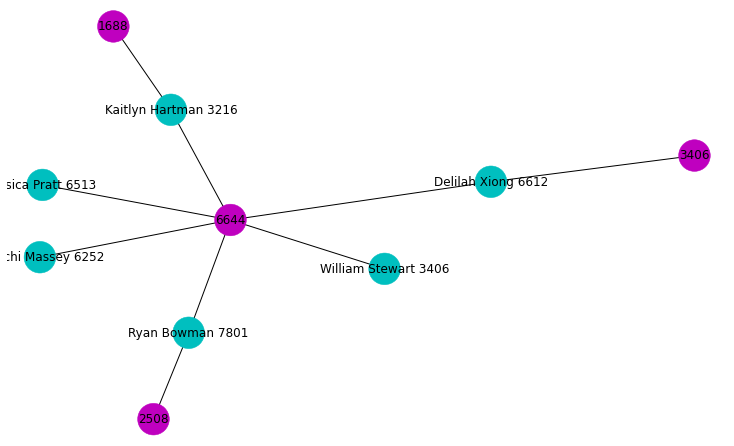

     name/individual ID  degrees
0    Delilah Xiong 6612        2
1    Jessica Pratt 6513        1
4      Ryan Bowman 7801        2
6   Malachi Massey 6252        1
7  William Stewart 3406        1
9  Kaitlyn Hartman 3216        2
  member_nbr  degrees
2       2508        1
3       3406        1
5       6644        6
8       1688        1


In [43]:
#specify subgraph
graph = multi[0]

colors = generate_color_map(graph)

#find center of graph and use it to determine name
center = nx.center(graph)
title = f'the {str(center[0])} network'

#determine number of degrees and nodes
degrees = nx.degree(graph)
node_count = len(nx.nodes(graph))

#layout for display
pos = nx.spring_layout(graph)

#function to separate membership from individuals for display
x,y = get_network_members(degrees)

#draw function
nx.draw(graph, pos=pos, node_color=colors, node_size=1000)

#add labels
nx.draw_networkx_labels(graph, pos=pos )

#Output
print(title)
print(f'{node_count} nodes')
plt.show()
#print(pd.DataFrame.from_dict(nx.degree(graph)))
print(x)
print(y)

The 6644 network
10 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


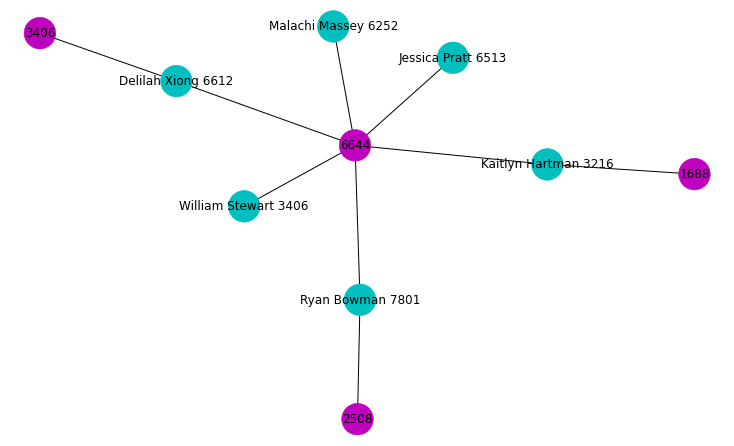

     name/individual ID  degrees
0  William Stewart 3406        1
3    Delilah Xiong 6612        2
4   Malachi Massey 6252        1
5      Ryan Bowman 7801        2
8  Kaitlyn Hartman 3216        2
9    Jessica Pratt 6513        1
  member_nbr  degrees
1       2508        1
2       3406        1
6       6644        6
7       1688        1
The 4684 network
6 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


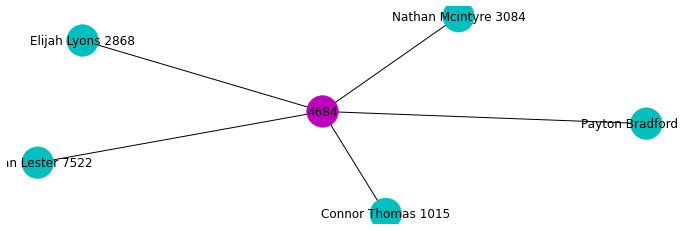

     name/individual ID  degrees
0     Ethan Lester 7522        1
1     Elijah Lyons 2868        1
3  Payton Bradford 7339        1
4  Nathan Mcintyre 3084        1
5    Connor Thomas 1015        1
  member_nbr  degrees
2       4684        5
The 5026 network
7 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


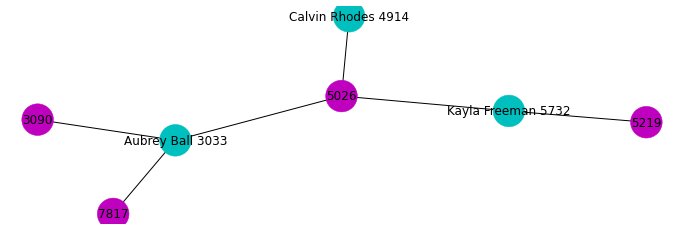

   name/individual ID  degrees
2  Calvin Rhodes 4914        1
4    Aubrey Ball 3033        3
6  Kayla Freeman 5732        2
  member_nbr  degrees
0       5026        3
1       5219        1
3       7817        1
5       3090        1
The 6779 network
7 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


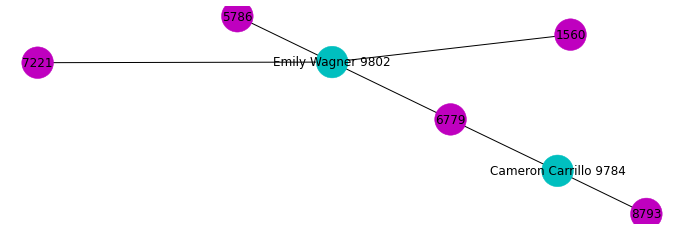

      name/individual ID  degrees
0      Emily Wagner 9802        4
6  Cameron Carrillo 9784        2
  member_nbr  degrees
1       7221        1
2       1560        1
3       8793        1
4       5786        1
5       6779        2
The 1906 network
9 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


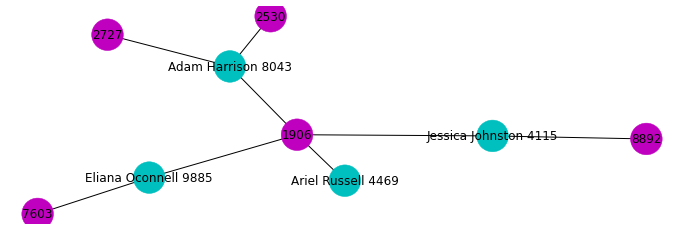

      name/individual ID  degrees
0   Eliana Oconnell 9885        2
3     Ariel Russell 4469        1
4  Jessica Johnston 4115        2
7     Adam Harrison 8043        3
  member_nbr  degrees
1       2530        1
2       2727        1
5       1906        4
6       7603        1
8       8892        1
The 4315 network
7 nodes


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


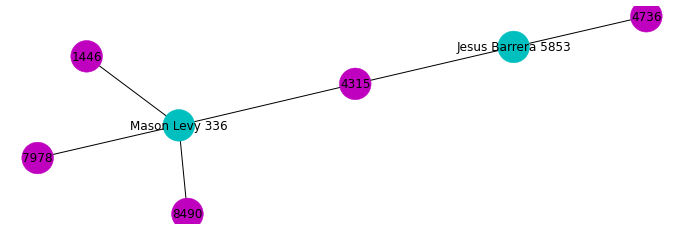

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


   name/individual ID  degrees
1      Mason Levy 336        4
3  Jesus Barrera 5853        2
  member_nbr  degrees
0       4736        1
2       1446        1
4       8490        1
5       7978        1
6       4315        2
The 1390 network
6 nodes


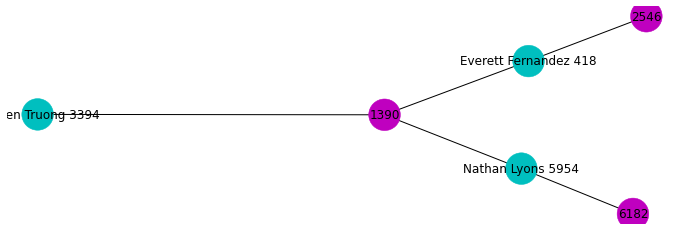

      name/individual ID  degrees
1      Nathan Lyons 5954        2
3     Kayden Truong 3394        1
5  Everett Fernandez 418        2
  member_nbr  degrees
0       6182        1
2       1390        3
4       2546        1
The 2650 network

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)



6 nodes


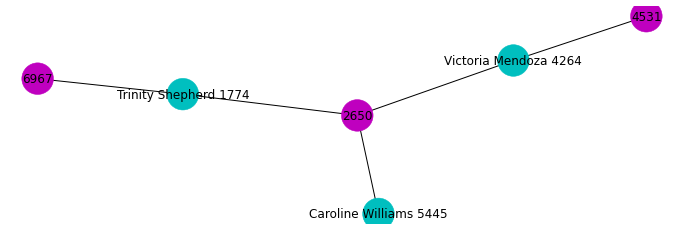

       name/individual ID  degrees
0   Trinity Shepherd 1774        2
1  Caroline Williams 5445        1
5   Victoria Mendoza 4264        2
  member_nbr  degrees
2       4531        1
3       6967        1
4       2650        3


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


The 4686 network
6 nodes


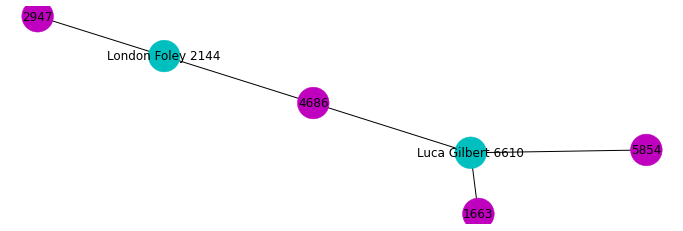

  name/individual ID  degrees
2  Luca Gilbert 6610        3
3  London Foley 2144        2
  member_nbr  degrees
0       2947        1
1       4686        2
4       5854        1
5       1663        1


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


The 6916 network
8 nodes


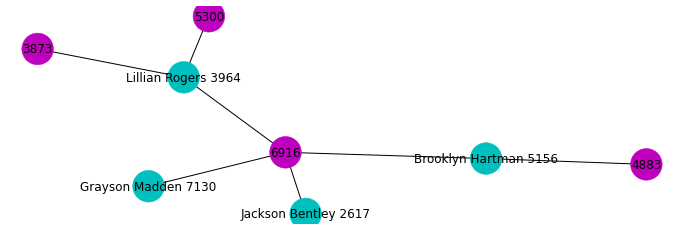

      name/individual ID  degrees
2  Brooklyn Hartman 5156        2
5   Jackson Bentley 2617        1
6    Lillian Rogers 3964        3
7    Grayson Madden 7130        1
  member_nbr  degrees
0       3873        1
1       6916        4
3       4883        1
4       5300        1


NameError: name 'df' is not defined

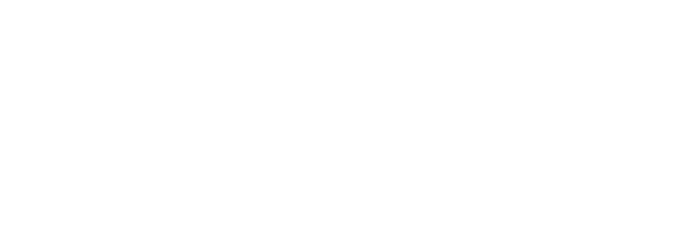

In [41]:
for i in range(10):
    
    graph = multi[i]
    
    individual_nodes = []

    for name in list(graph.nodes):
        if " " in str(name):
            individual_nodes.append(name)

    for n in graph.nodes:
        graph.nodes[n]['color']= 'c' if n in individual_nodes else 'm'
    
    colors = [node[1]['color'] for node in graph.nodes(data=True)]
    
    center = nx.center(graph)
    title = 'The '+str(center[0])+" network"
    degrees = nx.degree(graph)
    node_count = len(nx.nodes(graph))
    pos = nx.spring_layout(graph)
    
    x,y = get_network_members(degrees)
    
    # and then pass the positions to the drawing function
    nx.draw(graph, pos=pos, node_color=colors,   node_size=1000)

    # then we draw the labels at the same position
    nx.draw_networkx_labels(graph, pos=pos )
    print(title)
    print(str(node_count)+" nodes")
    plt.show()
    #print(pd.DataFrame.from_dict(nx.degree(graph)))
    print(x)
    print(y)
    
    
    fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()